In [21]:
# -*- coding: utf-8 -*-
import pandas as pd
from pandas._config import display
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import mean_absolute_error
from pandas.plotting import scatter_matrix
from ipywidgets import interact, widgets, FloatSlider, Button, Output
from IPython.display import display
import warnings

# ignore warning messages for presentation
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings(
    "ignore", message="X does not have valid feature names, but LinearRegression was fitted with feature names")

# Data to be combined
driverData = 'NewDrivers.csv'
resultData = 'NewResults.csv'
raceData = 'NewRaces.csv'
df1 = pd.read_csv(driverData)
df2 = pd.read_csv(resultData, low_memory=False)
df3 = pd.read_csv(raceData)

# convert to datetime object
df3['date'] = pd.to_datetime(df3['date'])

# Filter dates greater than or equal to 1998
filtered_df1 = df3[df3['date'].dt.year >= 1998]

NewMerge = pd.merge(df1, df2, on='driverId', how='inner')
mergedf3 = pd.merge(NewMerge, filtered_df1, on='raceId',
                    how='inner', suffixes=('_left', '_right'))
mergedf3['year'] = mergedf3['date'].dt.year


mergedf3['date'] = pd.to_datetime(mergedf3['date'])
mergedf3['dob'] = pd.to_datetime(
    mergedf3['dob'], format='mixed', dayfirst=True)

mergedf3['date_difference'] = mergedf3['date'] - mergedf3['dob']
mergedf3['years_difference'] = mergedf3['date_difference'] / \
    pd.Timedelta(days=365.25)
mergedf3['months_difference'] = mergedf3['date_difference'] / \
    pd.Timedelta(days=30.4375)

# Merge years and months into a single column to create age of driver column
mergedf3['age'] = mergedf3['years_difference'].astype(int).astype(
    str) + '.' + (mergedf3['months_difference'] % 12).astype(int).astype(str)

new_df = mergedf3.drop(['driverId', 'number_x', 'url_left', 'number_y', 'time_left', 'driverRef', 'milliseconds', 'rank', 'points', 'time_right', 'url_right', 'code', 'dob', 'nationality', 'resultId', 'duration', 'constructorId', 'position', 'positionText', 'laps', 'fastestLap', 'fastestLapTime',
                       'fastestLapSpeed', 'statusId', 'year', 'round', 'circuitId', 'name', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'date_difference', 'years_difference', 'months_difference'], axis=1, inplace=False)

# Exclude 0 from pit stop time,
#Exclude final postion of 1-9 to better illustrate correlations, and exclude grid postions over 14 to reduce noise
filtered_df = new_df[(new_df.iloc[:, 7] != 0) & (
    new_df.iloc[:, 4] < 10.0) & (new_df.iloc[:, 3] < 15)]

filtered_df = filtered_df.rename(columns={
    'date': 'Date',
    'raceId': 'RaceID',
    'surname': 'Last Name',
    'age': 'Age',
    'grid': 'Grid',
    'positionOrder': 'Position',
    'duration2': 'PitTime'
})
filtered_df = filtered_df[['Date', 'RaceID',
                           'Last Name', 'Age', 'Grid', 'Position', 'PitTime']]
display(filtered_df)

,Date,RaceID,Last Name,Age,Grid,Position,PitTime
0,2023-07-30,1110.0,Hamilton,38.0,3.0,4.0,2.4001
1,2023-07-30,1110.0,Alonso,42.0,9.0,5.0,2.3090
4,2023-07-30,1110.0,Pérez,33.6,2.0,2.0,2.4571
8,2023-07-30,1110.0,Verstappen,25.9,6.0,1.0,2.3638
10,2023-07-30,1110.0,Ocon,26.10,14.0,8.0,2.3303
...,...,...,...,...,...,...,...
10083,2000-05-21,163.0,Fisichella,27.4,7.0,5.0,0.0000
10084,2000-05-21,163.0,Barrichello,27.11,4.0,4.0,0.0000
10087,2000-05-21,163.0,Schumacher,31.2,2.0,1.0,0.0000
10089,2000-05-21,163.0,de la Rosa,29.2,12.0,6.0,0.0000


[7.36404946]


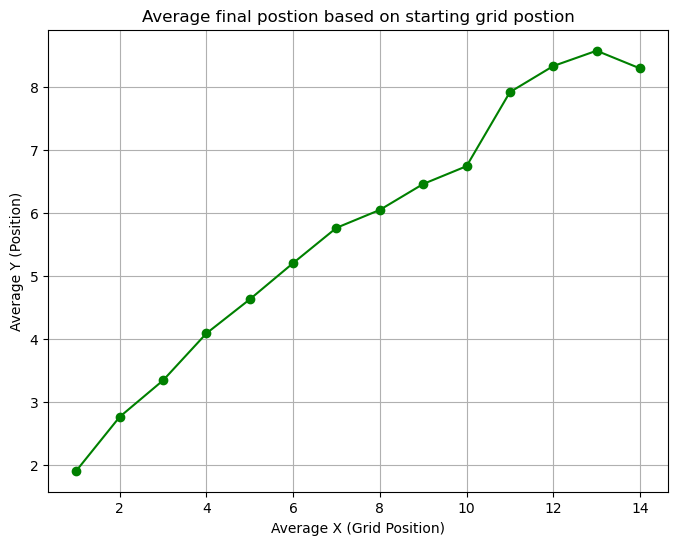

In [22]:
modelXX = linear_model.LinearRegression()
y = filtered_df.values[:, 5]
x = filtered_df.iloc[:, [4, 6, 3]]
x = filtered_df.iloc[:, [4, 6, 3]].values
# apply different parameter weight for pit stop time to reduce mean absolute error
x[:, 1] *= .2
# Applying penalty to the first parameter of grid postion above 10 to better align with actual spot data
y = np.where(x[:, 0] > 10, y + (y * .2), y)
modelXX.fit(x, y)

print(modelXX.predict([[1, 10.0, 20.5]]))

y_preD = modelXX.predict(x)
#maE = mean_absolute_error(y, y_preD)
#print("Mean Absolute Error11111:", maE)

xx = filtered_df.iloc[:, [4, 6, 3]]

average_y_by_x = pd.DataFrame({'X': xx.iloc[:, 0], 'Y': y})
average_y_by_x = average_y_by_x.groupby('X').mean().reset_index()

filtered_average_y_by_x = average_y_by_x[(
    average_y_by_x['X'] > 0) & (average_y_by_x['X'] <= 20)]

# Plotting average grid postion with final postion overall
plt.figure(figsize=(8, 6))
plt.plot(filtered_average_y_by_x['X'],
         filtered_average_y_by_x['Y'], marker='o', color='green')
plt.xlabel("Average X (Grid Position)")
plt.ylabel("Average Y (Position)")
plt.title("Average final postion based on starting grid postion")
plt.grid(True)
plt.show()

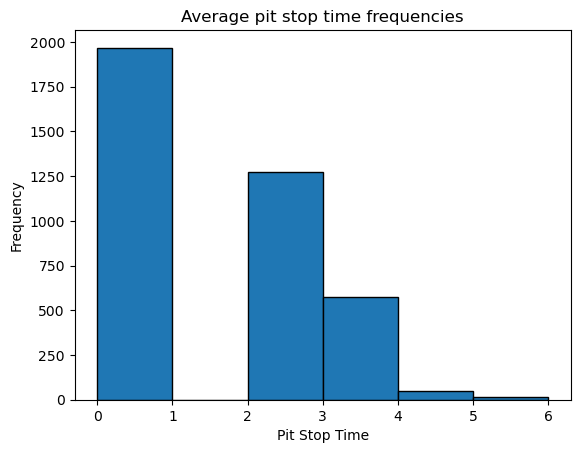

In [23]:
second_column_numeric = pd.to_numeric(filtered_df.iloc[:, 6])
# Round each number to the closest 0.5
rounded_values = np.round(second_column_numeric)

plt.hist(rounded_values, bins=6, edgecolor='black')
plt.xlabel('Pit Stop Time')
plt.ylabel('Frequency')
plt.title('Average pit stop time frequencies')
plt.show()

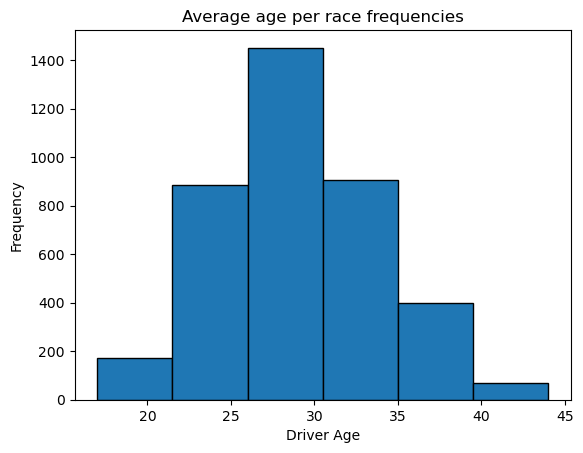

In [24]:
third_column_numeric = pd.to_numeric(filtered_df.iloc[:, 3])
# Round each number to the closest 0.5
roundedValues = np.round(third_column_numeric)

# Plot the histogram
# Adjust the number of bins as needed
plt.hist(roundedValues, bins=6, edgecolor='black')
plt.xlabel('Driver Age')
plt.ylabel('Frequency')
plt.title('Average age per race frequencies')
plt.show()


In [25]:
out = Output()

# The predict_position function

def predict_position(grid_position, pit_stop_time, age_of_driver):
    # Your function code here
    x = filtered_df.iloc[:, [4, 6, 3]].values
    y = filtered_df.iloc[:, 5].values

    # Applying penalty to the first parameter(grid position) for positions above 10 to better align with actual spot data
    y = np.where(x[:, 0] > 10, y + (y * 0.2), y)
    x[:, 1] *= 1

    # Fitting the model and predict based on user input
    modelXX.fit(x, y)
    input_data = np.array([[grid_position, pit_stop_time, age_of_driver]])
    predicted_value = modelXX.predict(input_data)

    return  predicted_value[0]


# Create interactive widget with sliders for input
interact_output = interact(
    predict_position,
    grid_position=FloatSlider(min=1, max=20, step=1,
                              value=20, description='Grid Position'),
    pit_stop_time=FloatSlider(min=1, max=6, step=0.5,
                              value=3.0, description='Pit Stop Time'),
    age_of_driver=FloatSlider(min=18, max=45, step=1,
                              value=22.5, description='Age of Driver'),
    __manual=True
)

# Function to calculate the predicted position when the button is clicked

def calculate_position(button):
    with out:
        out.clear_output()
        grid_position = interact_output.widget.children[0].value
        pit_stop_time = interact_output.widget.children[1].value
        age_of_driver = interact_output.widget.children[2].value

        result = predict_position(grid_position, pit_stop_time, age_of_driver)
        print(f"Final Predicted Position: {result}")


# Create a button
button = Button(description="Calculate")
button.on_click(calculate_position)

# Display the button and output 
display(button)
display(out)


interactive(children=(FloatSlider(value=20.0, description='Grid Position', max=20.0, min=1.0, step=1.0), Float…

Button(description='Calculate', style=ButtonStyle())

Output()

In [26]:
button = widgets.Button(description="Calculate MAE")
output = widgets.Output()

# Define the calculation and display logic


def calculate_mae(button):
    with output:
        output.clear_output()  # Clear previous output
        x = filtered_df.iloc[:, [4, 6, 3]].values
        y = filtered_df.iloc[:, 5].values
        y_pred = modelXX.predict(x)
        mae = mean_absolute_error(y, y_pred)
        print(f"Mean Absolute Error: {mae}")


# Attach the event handler to the button
button.on_click(calculate_mae)

# Display the button and output area
display(button, output)

Button(description='Calculate MAE', style=ButtonStyle())

Output()